In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree, model_selection, datasets, metrics, ensemble
import graphviz as gv
import seaborn as sns

In [2]:
car_df = pd.read_csv('carseats.csv')
car_df = car_df.drop(car_df.columns[0], axis=1)
car_df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [10]:
cat_car_df = car_df.copy()
cat_car_df['Sales'] = cat_car_df['Sales'] > 8
cat_car_df['Urban'] = cat_car_df['Urban'] == 'Yes'
cat_car_df['US'] = cat_car_df['US'] == 'Yes'
cat_car_df['ShelveLoc'] = cat_car_df['ShelveLoc'].map({'Bad' : 0, 'Medium': 1, 'Good' : 2})
cat_car_df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,True,138,73,11,276,120,0,42,17,True,True
1,True,111,48,16,260,83,2,65,10,True,True
2,True,113,35,10,269,80,1,59,12,True,True
3,False,117,100,4,466,97,1,55,14,True,True
4,False,141,64,3,340,128,0,38,13,True,False


In [135]:
clf = tree.DecisionTreeClassifier(max_depth=3)
x = cat_car_df.drop('Sales', axis=1)
y = cat_car_df.Sales
clf.fit(x,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [136]:
accuracy = (clf.predict(x) == y).sum() / len(y)
print('training error: {}'.format(1 - accuracy))

training error: 0.20750000000000002


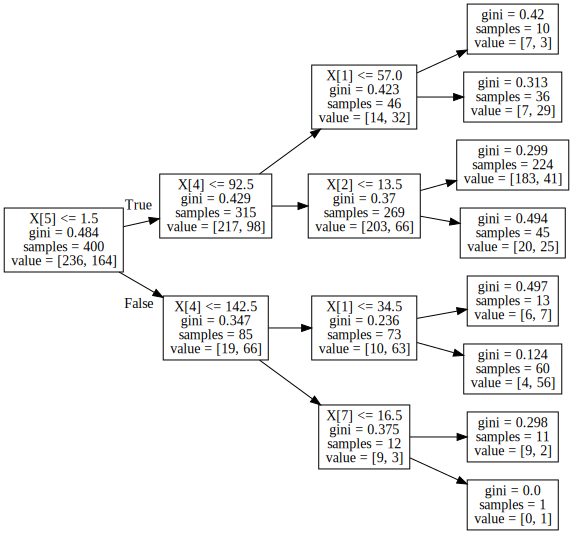

In [137]:
dot_dat = tree.export_graphviz(clf, out_file=None, rotate=True)
graph = gv.Source(dot_dat)
graph

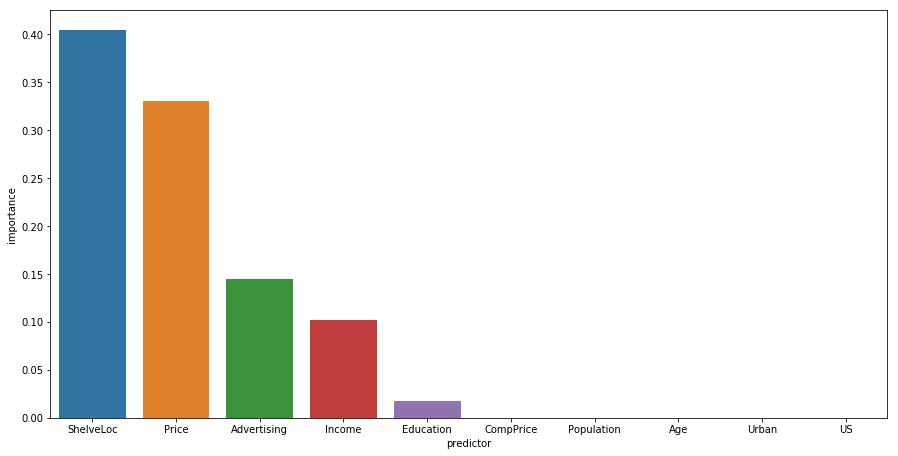

In [138]:
_,_ = plt.subplots(figsize=(15, 7.5))
bar_df = pd.DataFrame({'predictor': x.columns, 'importance' : clf.feature_importances_})
sns.barplot(x='predictor', y='importance', data=bar_df.sort_values('importance', ascending=False))

In [128]:
def run_cv(df, n_splits, extract_x, extract_y, fit_model, loss_fn):
    cv_result = pd.DataFrame()
    for train_idx, test_idx in model_selection.KFold(n_splits=n_splits).split(df):
        train, test = df.iloc[train_idx], df.iloc[test_idx]
        errors = []
        # train
        train_X = extract_x(train)
        train_y = extract_y(train)
        model = fit_model(train_X, train_y)
        # test
        test_X =  extract_x(test)
        test_y = extract_y(test)
        preds = model.predict(test_X)
        errors.append(loss_fn(preds, test_y))
        cv_result = cv_result.append(pd.Series(errors), ignore_index=True)
    return cv_result

In [140]:
cv_result = run_cv(cat_car_df,
                   10,
                   lambda df: df.drop('Sales', axis=1),
                   lambda df:  df.Sales,
                   lambda x, y: tree.DecisionTreeClassifier(max_depth=3).fit(x,y),
                   lambda preds, true: 1 - ((preds == true).sum() / len(true))) 

print('test error :\n {}'.format(cv_result.mean()[0]))

test error :
 0.30250000000000005


In [112]:
# post pruning is not available out of the box in SKLearn - https://github.com/scikit-learn/scikit-learn/issues/6557
# seems like in practice, bagging, random forests and boosting are the preferred method by
# which to reduce variance so I'm going to skip this - I may well spend the time saved taking
# XGBoost out for a spin.

In [141]:
boston_df = datasets.load_boston()
boston_df = pd.DataFrame(data=np.c_[boston_df['data'], boston_df['target']], columns= [c for c in boston_df['feature_names']] + ['Price'])
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [142]:
reg = tree.DecisionTreeRegressor(max_depth=3) 
x = boston_df.drop('Price', axis=1)
y = boston_df.Price
reg.fit(x,y)
preds = reg.predict(x)
rmse = np.sqrt(metrics.mean_squared_error(y, preds))
print('training rmse: {}'.format(rmse))

training rmse: 3.9272517351998024


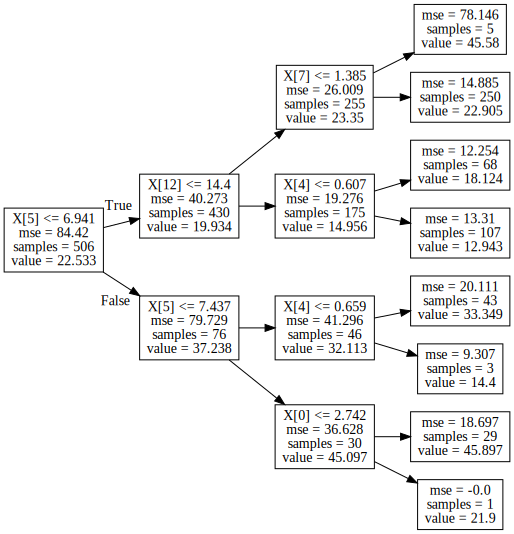

In [144]:
dot_dat = tree.export_graphviz(reg, out_file=None, rotate=True)
graph = gv.Source(dot_dat)
graph

In [146]:
cv_result = run_cv(boston_df,
                   10,
                   lambda df: df.drop('Price', axis=1),
                   lambda df:  df.Price,
                   lambda x, y: tree.DecisionTreeRegressor().fit(x,y), #max_depth=3
                   lambda preds, true: np.sqrt(metrics.mean_squared_error(true, preds)))  

print('test error :\n {}'.format(cv_result.mean()[0]))

test error :
 5.565254939640856


In [154]:
reg = ensemble.RandomForestRegressor(n_estimators=100, max_features='sqrt')
x = boston_df.drop('Price', axis=1)
y = boston_df.Price
reg.fit(x,y)
preds = reg.predict(x)
rmse = np.sqrt(metrics.mean_squared_error(y, preds))
print('training rmse: {}'.format(rmse))

training rmse: 1.1877736913643233


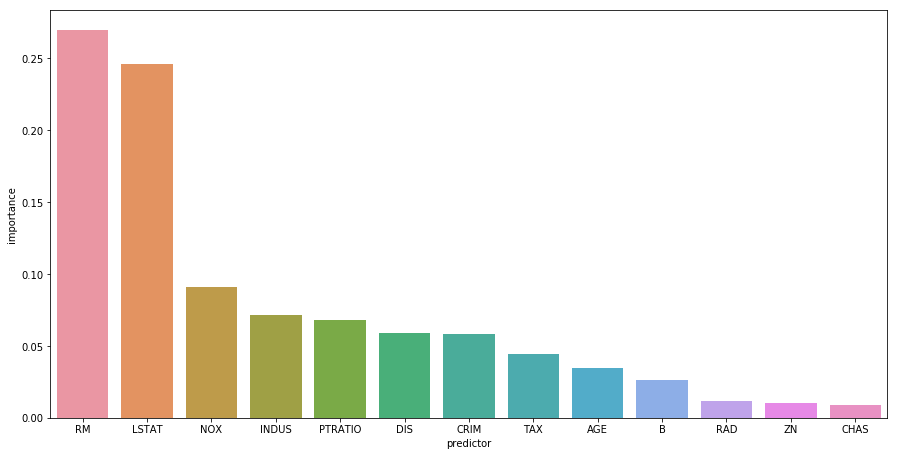

In [155]:
_,_ = plt.subplots(figsize=(15, 7.5))
bar_df = pd.DataFrame({'predictor': x.columns, 'importance' : reg.feature_importances_})
sns.barplot(x='predictor', y='importance', data=bar_df.sort_values('importance', ascending=False))

In [156]:
cv_result = run_cv(boston_df,
                   10,
                   lambda df: df.drop('Price', axis=1),
                   lambda df:  df.Price,
                   lambda x, y: ensemble.RandomForestRegressor(n_estimators=100, max_features='sqrt').fit(x,y),
                   lambda preds, true: np.sqrt(metrics.mean_squared_error(true, preds)))  

print('test error :\n {}'.format(cv_result.mean()[0]))

test error :
 4.166150081210072


In [158]:
reg = ensemble.GradientBoostingRegressor(n_estimators=100, max_features='sqrt')
x = boston_df.drop('Price', axis=1)
y = boston_df.Price
reg.fit(x,y)
preds = reg.predict(x)
rmse = np.sqrt(metrics.mean_squared_error(y, preds))
print('training rmse: {}'.format(rmse))

training rmse: 1.6385223451873687


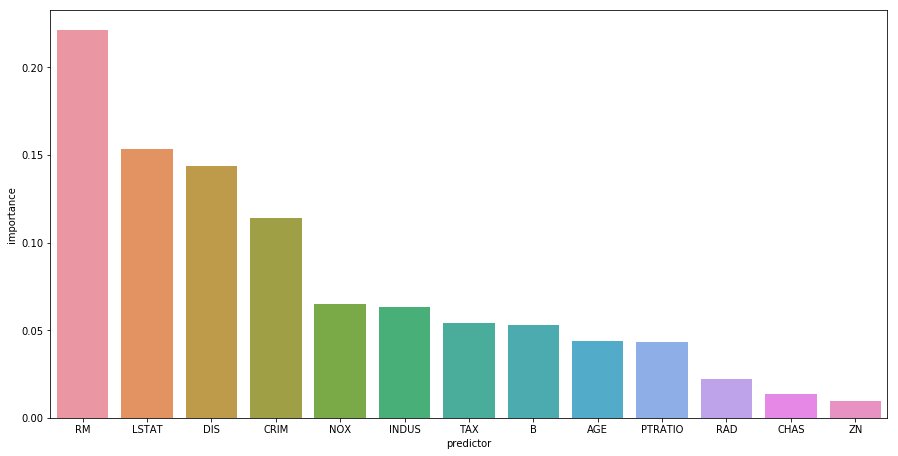

In [160]:
_,_ = plt.subplots(figsize=(15, 7.5))
bar_df = pd.DataFrame({'predictor': x.columns, 'importance' : reg.feature_importances_})
sns.barplot(x='predictor', y='importance', data=bar_df.sort_values('importance', ascending=False))

In [161]:
cv_result = run_cv(boston_df,
                   10,
                   lambda df: df.drop('Price', axis=1),
                   lambda df:  df.Price,
                   lambda x, y: ensemble.GradientBoostingRegressor(n_estimators=100, max_features='sqrt').fit(x,y),
                   lambda preds, true: np.sqrt(metrics.mean_squared_error(true, preds)))  

print('test error :\n {}'.format(cv_result.mean()[0]))

test error :
 3.9510318841965826
